In [2]:
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import pyfolio
import datetime
%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [124]:
# Extract columns from dataframe
df_cur1 = pd.read_csv('2012-2017_EU.csv')
cur1_col1 = df_cur1.iloc[:, 4].values
cur1_index = df_cur1.iloc[:, 0].values
cur1_volume = df_cur1.iloc[:, 5].values
#cur1_col2 = df_cur1.iloc[1]

ii = 0
for i in range(len(cur1_col1)):
    if cur1_volume[i] > 0:
        cur1_col1[ii] = cur1_col1[i]
        ii += 1

df_cur2 = pd.read_csv('2012-2017_EC.csv')
cur2_col1 = df_cur2.iloc[:, 4].values
cur2_index = df_cur2.iloc[:, 0].values
cur2_volume = df_cur2.iloc[:, 5].values
#cur2_col2 = df_cur2.iloc[1]

jj = 0
for j in range(len(cur2_col1)):
    if cur2_volume[j] > 0:
        cur2_col1[jj] = cur2_col1[j]
        jj += 1

print(cur1_index[:1])
print(cur2_index[:1])

['02.01.2012 00:00:00.000']
['02.01.2012 00:00:00.000']


In [125]:
# Sample size parameter
samplesize = 500

# Array inits
other_ratio, this_ratio, cur1_localmax, cur2_localmax, cur1_localmin, cur2_localmin = ([] for i in range(6))

# Speed measuring
ping = time.process_time()

# First calc
cur1_localmax.insert(0, float(max(cur1_col1[:samplesize])))
cur2_localmax.insert(0, float(max(cur2_col1[:samplesize])))
cur1_localmin.insert(0, float(min(cur1_col1[:samplesize])))
cur2_localmin.insert(0, float(min(cur2_col1[:samplesize])))

for i in range(samplesize, len(cur1_col1)-1):
    # Get localmaxes and localmins respectively from extracted datasets

    # Array boundary precausions
    if i > 0: 
        # Cur1 max
        if cur1_col1[i] > cur1_localmax[i-samplesize-1]:
            cur1_localmax.insert(i-samplesize, cur1_col1[i])
        elif cur1_localmax[i-samplesize-1] == cur1_col1[i-samplesize-1]:
            cur1_localmax.insert(i-samplesize, float(max(cur1_col1[i-samplesize:i])))
        else:
            cur1_localmax.insert(i-samplesize, cur1_localmax[i-samplesize-1])
        
        # Cur2 max
        if cur2_col1[i] > cur2_localmax[i-samplesize-1]:
            cur2_localmax.insert(i-samplesize, cur2_col1[i])
        elif cur2_localmax[i-samplesize-1] == cur2_col1[i-samplesize-1]:
            cur2_localmax.insert(i-samplesize, float(max(cur2_col1[i-samplesize:i])))
        else:
            cur2_localmax.insert(i-samplesize, cur2_localmax[i-samplesize-1])
        
        # Cur1 min
        if cur1_col1[i] < cur1_localmin[i-samplesize-1]:
            cur1_localmin.insert(i-samplesize, cur1_col1[i])
        elif cur1_localmin[i-samplesize-1] == cur1_col1[i-samplesize-1]:
            cur1_localmin.insert(i-samplesize, float(min(cur1_col1[i-samplesize:i])))
        else:
            cur1_localmin.insert(i-samplesize, cur1_localmin[i-samplesize-1])
        
        # Cur2 min
        if cur2_col1[i] < cur2_localmin[i-samplesize-1]:
            cur2_localmin.insert(i-samplesize, cur2_col1[i])
        elif cur2_localmin[i-samplesize-1] == cur2_col1[i-samplesize-1]:
            cur2_localmin.insert(i-samplesize, float(min(cur2_col1[i-samplesize:i])))
        else:
            cur2_localmin.insert(i-samplesize, cur2_localmin[i-samplesize-1])
        
        # Calculate ratios
        o_r = (cur2_col1[i] - cur2_localmin[i-samplesize-1])/(cur2_localmax[i-samplesize-1] - cur2_localmin[i-samplesize-1])
        t_r = (cur1_col1[i] - cur1_localmin[i-samplesize-1])/(cur1_localmax[i-samplesize-1] - cur1_localmin[i-samplesize-1])
        # Prevent o_r !E {[0,1]}
        if o_r > 1:
            other_ratio.insert(i-samplesize, 1)
        elif o_r < 0:
            other_ratio.insert(i-samplesize, 0)
        else:
            other_ratio.insert(i-samplesize, o_r)
            
        if t_r > 1:
            this_ratio.insert(i-samplesize, 1)
        elif t_r < 0:
            this_ratio.insert(i-samplesize, 0)
        else:
            this_ratio.insert(i-samplesize, t_r)
            
        # Simple progress bar
        if i % (math.floor((len(cur1_col1)-1-samplesize)/10)) == 0:
            print('+ '*math.ceil(((len(cur1_col1)-1-samplesize)/10/i)**-1),
                  '- '*(10-math.ceil(((len(cur1_col1)-1-samplesize)/10/i)**-1)), sep='')

# Print elapsed time
pong = time.process_time()
print(pong-ping, 'seconds elapsed')

+ - - - - - - - - - 
+ + - - - - - - - - 
+ + + - - - - - - - 
+ + + + - - - - - - 
+ + + + + - - - - - 
+ + + + + + - - - - 
+ + + + + + + - - - 
+ + + + + + + + - - 
+ + + + + + + + + - 
+ + + + + + + + + + 
0.8125 seconds elapsed


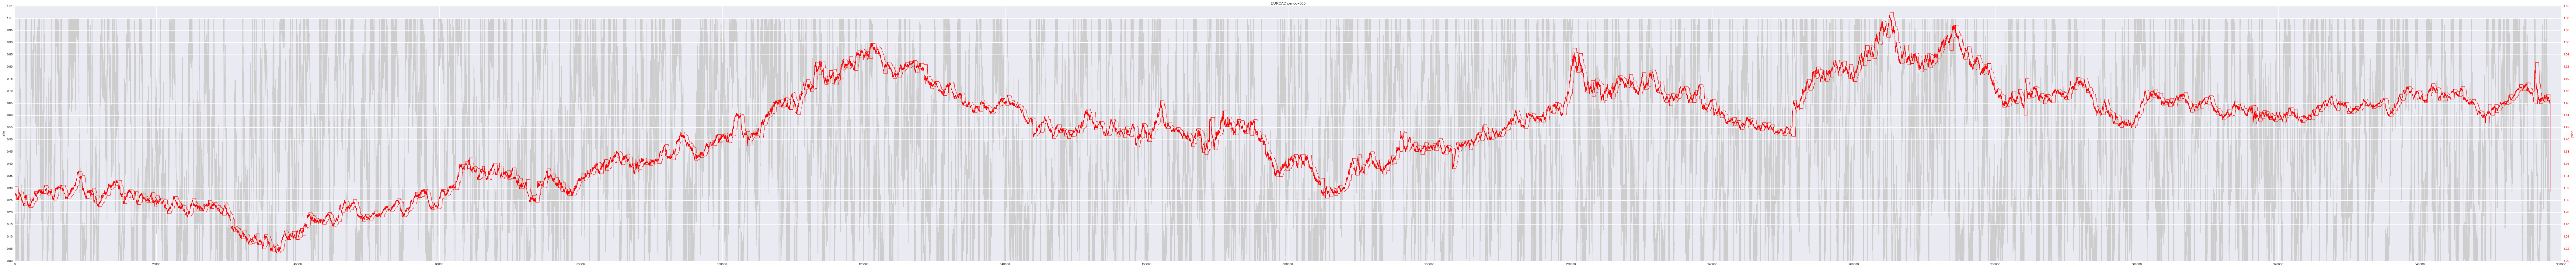

In [109]:
# Preparing to plot on multiple y-axes
fig = plt.figure(figsize=(150, 15))
ax1 = fig.add_subplot(111)

ax1.plot(other_ratio, '#cdcdcd')
ax1.plot([1]*len(other_ratio), '#cdcdcd', linewidth=1.0)
ax1.plot([0]*len(other_ratio), '#cdcdcd', linewidth=1.0)
ax1.set_ylabel('ratio')
ax1.locator_params(nbins=30)

# Add subplot with different axis range
ax2 = ax1.twinx()
ax2.plot(cur2_localmax, 'r', linewidth=1.0)
ax2.plot(cur2_localmin, 'r', linewidth=1.0)
ax2.plot(cur2_col1[samplesize:len(other_ratio)+samplesize], 'r', linewidth=1.0)
ax2.locator_params(nbins=30)
ax2.set_ylabel('price', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

plt.title('EURCAD period=' + str(samplesize))
plt.xlabel('(ticks)')
#plt.show()
plt.savefig('EURCAD_coint.pdf')

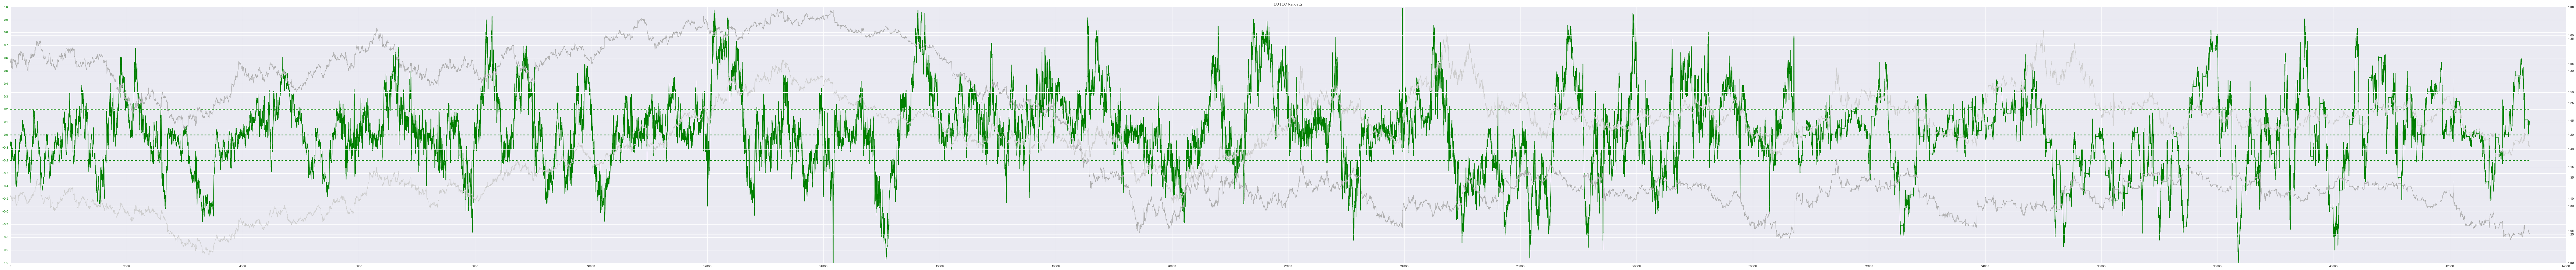

In [126]:
# Visualize ratio with currencies
# ---

fig2 = plt.figure(figsize=(150, 15))
ax2_1 = fig2.add_subplot(111)
ax2_2 = fig2.add_subplot(111)

# Calculate ratio delta array
delta = [other_ratio[i] - this_ratio[i] for i in range(len(other_ratio))]

# Plot delta with thresholds
ax2_2.plot(delta, 'g')
ax2_2.plot([0.2]*len(other_ratio), 'g--')
ax2_2.plot([0]*len(other_ratio), 'g--')
ax2_2.plot([-0.2]*len(other_ratio), 'g--')

for tl in ax2_1.get_yticklabels():
    tl.set_color('g')
'''
ax2_1.plot(this_ratio, 'r')
ax2_1.plot(other_ratio, 'b')
'''
ax2_1.twinx().plot(cur2_col1[samplesize:len(other_ratio)+samplesize], '#cdcdcd', linewidth=1.0)
ax2_1.twinx().plot(cur1_col1[samplesize:len(other_ratio)+samplesize], '#adadad', linewidth=1.0)
ax2_1.locator_params(nbins=30)
plt.title('EU | EC Ratios $\Delta$')
plt.savefig('ratios_coint.pdf')
#plt.show()

In [127]:
# Simple backtesting engine for hedging pairs trading
# ---

class order():
    def order_open(self):
        pass
    def order_close(self):
        pass
    

trade_1 = 0 #EURUSD 
trade_2 = 0 #EURCAD
ev, ev_1, ev_2 = [0]*3 # iters
open_rates = [0]*2
entryvals =  [0]*len(delta)
typevals =   [0]*len(delta)

# Exitvals 1 & 2 because of positions on two symbols
exitvals_1 = [0]*len(delta)
exitvals_2 = [0]*len(delta)
net_pips_1 = [0]
net_pips_2 = [0]
np_1 = 1 #(net pips iter)
np_2 = 1

wins = 0
losses = 0

# Parameters
# > compute sl/tp as fraction of volatility / ML-smarts
deltaval = 0.2 #Threshold for Delta_ratios for trades
target_1 = 1#0.01
stop_1 = 1#0.003
target_2 = 1#0.01
stop_2 = 1#0.003

for x in range(len(other_ratio)):
    # if all closed
    if trade_1 == trade_2 == 0:
        if delta[x] >= deltaval:
            tradetype = 1 # ><
            open_rates[0] = cur1_col1[samplesize+x]
            open_rates[1] = cur2_col1[samplesize+x]
            # Trades = open
            trade_1 = 1 # Keeping track of both trades simultaneously, also allows different stops/targets
            trade_2 = 1 # ''
            entryvals[ev] = x # Store position in delta array
            typevals[ev] = 1 # For line coloring in backtest visualization
            ev += 1

        elif delta[x] <= -deltaval:
            tradetype = 0 # <>
            open_rates[0] = cur1_col1[samplesize+x]
            open_rates[1] = cur2_col1[samplesize+x]
            # Trades = open
            trade_1 = 1 # Keeping track of both trades simultaneously, also allows different stops/targets
            trade_2 = 1 # ''
            entryvals[ev] = x # Store position in delta array
            typevals[ev] = 0 # For line coloring in backtest visualization
            ev += 1
            
    
    # if >0 open
    else:
        # ><
        if tradetype == 1:
            if trade_1 == 1:
                if -0.01 < delta[x] < 0.01:
                    net_pips_1.insert(np_1, net_pips_1[np_1-1] + (open_rates[0] - cur1_col1[samplesize+x])*10000)
                    np_1 += 1
                    trade_1 = 0
                    exitvals_1[ev_1] = x # Store position in delta array
                    ev_1 += 1
                    if open_rates[0] < cur1_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1
                    continue
                    
                if cur1_col1[samplesize+x] <= open_rates[0] - target_1 or cur1_col1[samplesize+x] >= open_rates[0] + stop_1:
                    # > Adjust pips by EC/EU worth
                    net_pips_1.insert(np_1, net_pips_1[np_1-1] + (open_rates[0] - cur1_col1[samplesize+x])*10000)
                    np_1 += 1
                    trade_1 = 0
                    exitvals_1[ev_1] = x # Store position in delta array
                    ev_1 += 1
                    if open_rates[0] < cur1_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1
                    
            if trade_2 == 1:
                if -0.01 < delta[x] < 0.01:
                    net_pips_2.insert(np_2, net_pips_2[np_2-1] + (cur2_col1[samplesize+x] - open_rates[1])*10000)
                    np_2 += 1
                    trade_2 = 0
                    exitvals_2[ev_2] = x # Store position in delta array
                    ev_2 += 1
                    if open_rates[1] > cur2_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1
                    continue
                    
                if cur2_col1[samplesize+x] >= open_rates[0] + target_2 or cur1_col1[samplesize+x] <= open_rates[0] - stop_2:
                    # > Adjust pips by EC/EU worth
                    net_pips_2.insert(np_2, net_pips_2[np_2-1] + (cur2_col1[samplesize+x] - open_rates[1])*10000)
                    np_2 += 1
                    trade_2 = 0
                    exitvals_2[ev_2] = x # Store position in delta array
                    ev_2 += 1
                    if open_rates[1] > cur2_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1
        
        # ><
        else:
            if trade_1 == 1:
                if -0.01 < delta[x] < 0.01:
                    net_pips_2.insert(np_2, net_pips_2[np_2-1] + (cur2_col1[samplesize+x] - open_rates[1])*10000)
                    np_2 += 1
                    trade_1 = 0
                    exitvals_1[ev_1] = x # Store position in delta array
                    ev_1 += 1
                    if open_rates[1] > cur2_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1
                    continue

                if cur2_col1[samplesize+x] >= open_rates[0] + target_2 or cur1_col1[samplesize+x] <= open_rates[0] - stop_2:
                    # > Adjust pips by EC/EU worth
                    net_pips_2.insert(np_2, net_pips_2[np_2-1] + (cur2_col1[samplesize+x] - open_rates[1])*10000)
                    np_2 += 1
                    trade_1 = 0
                    exitvals_1[ev_1] = x # Store position in delta array
                    ev_1 += 1
                    if open_rates[1] < cur2_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1
                    
            if trade_2 == 1:
                if -0.01 < delta[x] < 0.01:
                    net_pips_1.insert(np_1, net_pips_1[np_1-1] + (open_rates[0] - cur1_col1[samplesize+x])*10000)
                    np_1 += 1
                    trade_2 = 0
                    exitvals_2[ev_2] = x # Store position in delta array
                    ev_2 += 1
                    if open_rates[0] < cur1_col1[samplesize+x] - 2:
                        losses += 1
                    else:
                        wins += 1
                    continue
                    
                if cur1_col1[samplesize+x] <= open_rates[0] - target_1 or cur1_col1[samplesize+x] >= open_rates[0] + stop_1:
                    # > Adjust pips by EC/EU worth
                    net_pips_1.insert(np_1, net_pips_1[np_1-1] + (open_rates[0] - cur1_col1[samplesize+x])*10000)
                    np_1 += 1
                    trade_2 = 0
                    exitvals_2[ev_2] = x # Store position in delta array
                    ev_2 += 1
                    if open_rates[0] < cur1_col1[samplesize+x] - 2:
                        losses += 1
                    else:
                        wins += 1

# Store rates in arrays
def getOpenRates(rate1, rate2):
    open_rates = [0]*2
    open_rates[0] = rate1
    open_rates[1] = rate2
    return open_rates

    '''
    >
    fix target issue
    improve spread consideration
        load historical spread data
    consider intrinsic pip value
    expand on class to simplify clause
        enable support for other strategies
    implement pyfolio support
    '''

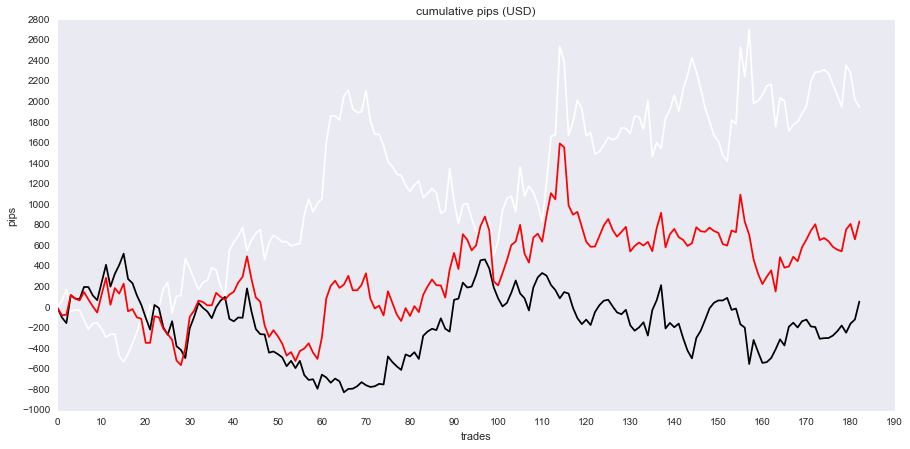

wins: 220
losses: 145
win%: 0.6027397260273972


In [128]:
# Profit plot
# ---

# 1.32 = EURCAD/EURUSD
# - 4 = 2 pips crossing 2 spreads

# > impl. net_pips_x for len
if len(net_pips_1) < len(net_pips_2):
    net_pips_x = len(net_pips_1)
else:
    net_pips_x = len(net_pips_2)
    
    
cumulative_net = [net_pips_2[i]*0.76 + net_pips_1[i] - 4*i for i in range(net_pips_x)]
net_pips_1_1 = [net_pips_1[j]*0.76 for j in range(net_pips_x)]

fig4 = plt.figure(figsize = (15, 7))
ax3 = fig4.add_subplot(111)
ax3.plot(net_pips_2, '#ffffff')
ax3.plot(net_pips_1_1, '#000000')
ax3.plot(cumulative_net, 'r')
ax3.locator_params(nbins=30)
plt.title('cumulative pips (USD)')
ax3.set_xlabel('trades')
ax3.set_ylabel('pips')
ax3.grid()
plt.show()

print('wins:', wins)
print('losses:', losses)

# out of whack
print('win%:', wins/(wins+losses))

In [157]:
print(net_pips_2[:])
print(net_pips_1[:])

[0, array([ 0.9]), array([ 4.1]), array([ 4.]), array([ 4.1]), array([ 4.]), array([ 3.9]), array([ 3.8]), array([ 3.7])]
[0, array([-46.9]), array([-46.]), array([-46.5]), array([-21.9]), array([-13.5]), array([-5.]), array([ 7.8])]


In [163]:
#https://github.com/quantopian/pyfolio/blob/master/pyfolio/examples/overview_slides.ipynb

start_date = datetime.date(2012, 1, 2)
end_date   = datetime.date(2017, 1, 2)

days = [start_date + datetime.timedelta(n) for n in range(int ((end_date - start_date).days))]

to_index = [0]
for k in range(len(cumulative_net)):
    to_index.insert(k, days[k])

#trade_return = [0]
trade_return[0] = 0

for i in range(0, len(cumulative_net)):
    trade_return.insert(i, (cumulative_net[i-1] - cumulative_net[i])/(cumulative_net[i]+5000))

#to_df = [{'Date': to_index[:], 'strat-rets': trade_return[:]}] 
#df = pd.DataFrame(to_df)
#df.truncate(before='2016-03-01')

#print(len(cur1_index[entryvals[:]]))

# FFS index shit again. Assuming equal list len
ii = 0
entryvals_ = []
for i in range(len(entryvals)):
    if entryvals[i] > 0:
        entryvals_.insert(ii, entryvals[i])
        ii += 1
        
print(cur1_index[entryvals[1]])
#plt.plot(entryvals_)
#df = pd.DataFrame(
#     index=cur1_index[entryvals[:]],
#     data=trade_return)

'''
#df = pyfolio.utils.get_symbol_rets('GOOGL')
#print(to_df)

#pyfolio.create_returns_tear_sheet(df)
#pyfolio.create_returns_tear_sheet(trade_return)
'''

13.01.2012 14:00:00.000


"\n#df = pyfolio.utils.get_symbol_rets('GOOGL')\n#print(to_df)\n\n#pyfolio.create_returns_tear_sheet(df)\n#pyfolio.create_returns_tear_sheet(trade_return)\n"

In [104]:
df = pd.DataFrame(to_df)
print(df)


NameError: name 'to_df' is not defined

In [21]:
print(len(trade_return))
print(len(to_index))

85
85


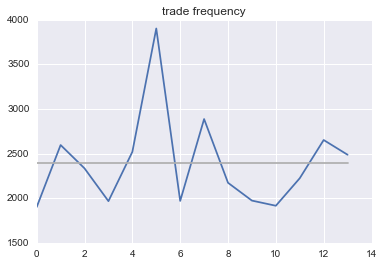

In [188]:
# Plot approximate trade frequency
to_int = []
for nn in range(len(entryvals)):
    if nn > 0 and entryvals[nn] == 0:
        break
    to_int.insert(nn, entryvals[nn])

int_ = []
for evi in range(10, len(to_int), 10):
    int_.insert(evi, (to_int[evi] - to_int[evi-10])/10)

plt.plot(int_)
plt.plot([sum(int_)/len(int_)]*len(int_), '#afafaf')
plt.title('trade frequency')
plt.show()

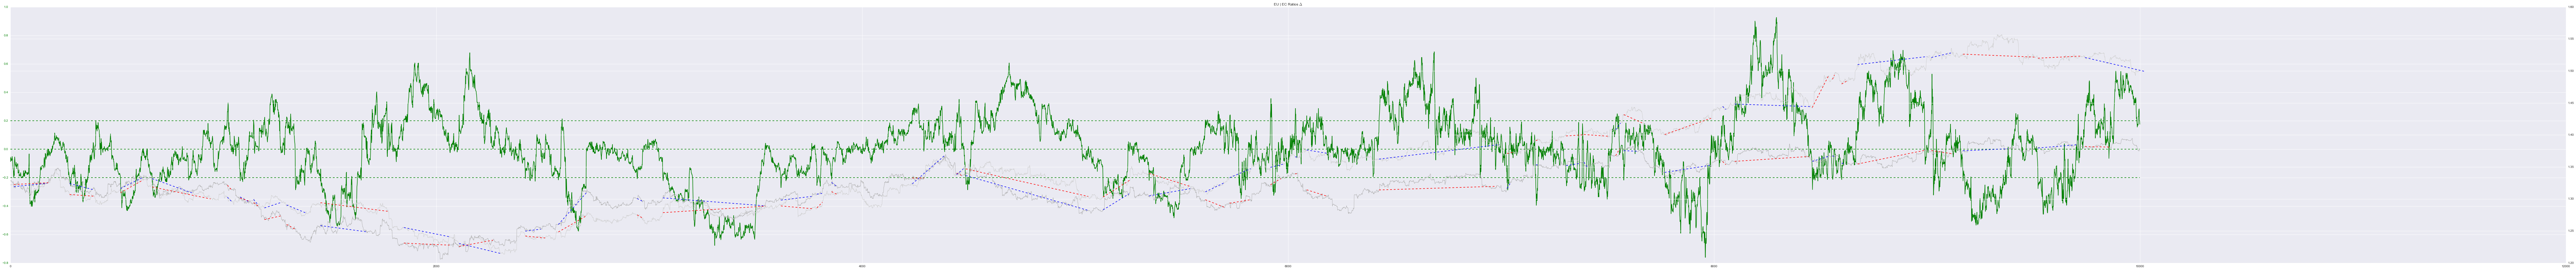

In [164]:
render_lim = 10000
render_shift = 0 #200000

fig6 = plt.figure(figsize=(150, 15))
#ax5_1 = fig5.add_subplot(111)
ax6_2 = fig6.add_subplot(111)

# Calculate ratio delta array
#delta = [other_ratio[i] - this_ratio[i] for i in range(len(other_ratio))]

# Plot delta with thresholds
ax6_2.plot(delta[render_shift:render_lim + render_shift], 'g')
ax6_2.plot([deltaval]*render_lim, 'g--')
ax6_2.plot([0]*render_lim, 'g--')
ax6_2.plot([-deltaval]*render_lim, 'g--')

for tl in ax6_2.get_yticklabels():
    tl.set_color('g')

# Plot correctly shifted quote values
#ax6_2.locator_params(nbins=30)
ax6_twinx = ax6_2.twinx()
ax6_twinx.plot(cur2_col1[samplesize + render_shift:render_lim + render_shift + samplesize], '#cdcdcd', linewidth=1.0)
ax6_twinx.plot(cur1_col1[samplesize + render_shift:render_lim + render_shift + samplesize], '#adadad', linewidth=1.0)

# Fast forward to correct entry/exit values in terms of render shift input
# Limiting backtester to a theoretical 99999 trades
for p in range(99999): 
    break

for k in range(render_lim):
    if exitvals_1[k] > render_lim and exitvals_2[k] > render_lim:
        break
    else:
        # Color trade-lines by type (<> | ><)
        if typevals[k] == 1:
            ax6_twinx.plot([entryvals[k], exitvals_1[k]], [cur1_col1[samplesize + entryvals[k]], cur1_col1[samplesize + exitvals_1[k]]], 'r--')
            ax6_twinx.plot([entryvals[k], exitvals_2[k]], [cur2_col1[samplesize + entryvals[k]], cur2_col1[samplesize + exitvals_2[k]]], 'b--')
        else:
            ax6_twinx.plot([entryvals[k], exitvals_1[k]], [cur1_col1[samplesize + entryvals[k]], cur1_col1[samplesize + exitvals_1[k]]], 'b--')
            ax6_twinx.plot([entryvals[k], exitvals_2[k]], [cur2_col1[samplesize + entryvals[k]], cur2_col1[samplesize + exitvals_2[k]]], 'r--')
        
plt.title('EU | EC Ratios $\Delta$')
plt.savefig('ratios_coint.pdf')
#plt.show()